Authors:

- Kacper Kuźnik 75267
- Mikołaj Nowacki 75231

In [ ]:
%pip install --upgrade torch torchvision torchaudio transformers ultralytics torchmetrics pycocotools timm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_root = "/content/drive/MyDrive/CV-project/Taco_subset"

# Load Dataset

In [ ]:
from torchvision.datasets import CocoDetection
from torchvision import transforms
from torchmetrics.detection.mean_ap import MeanAveragePrecision

transform = transforms.ToTensor()

train_dataset = CocoDetection(
    root=dataset_root,
    annFile=f"{dataset_root}/annotations_train.json",
    transform=transform
)

val_dataset = CocoDetection(
    root=dataset_root,
    annFile=f"{dataset_root}/annotations_val.json",
    transform=transform
)

test_dataset = CocoDetection(
    root=dataset_root,
    annFile=f"{dataset_root}/annotations_test.json",
    transform=transform
)


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


# Compute Statistics

In [ ]:
from collections import Counter
import pandas as pd

def class_stats(coco_dataset):
    categories = {cat["id"]: cat["name"] for cat in coco_dataset.coco.loadCats(coco_dataset.coco.getCatIds())}

    counter = Counter()

    for _, anns in coco_dataset:
        for ann in anns:
            counter[ann["category_id"]] += 1

    df = pd.DataFrame([
        {"class_id": cid, "class_name": categories[cid], "count": count}
        for cid, count in counter.items()
    ]).sort_values("class_id")

    return df

train_stats_df = class_stats(train_dataset)
val_stats_df   = class_stats(val_dataset)
test_stats_df  = class_stats(test_dataset)

merged = train_stats_df.merge(val_stats_df, on=["class_id","class_name"], how="outer", suffixes=("_train", "_val"))
merged = merged.merge(test_stats_df, on=["class_id","class_name"], how="outer")
merged = merged.rename(columns={"count": "count_test"}).fillna(0)

display(merged)


class_id             class_name  count_train  count_val  count_test
0         0  Plastic bag & wrapper          580        129         141
1         1              Cigarette          482         63         122
2         2                 Bottle          314         71          54
3         3             Bottle cap          219         38          32
4         4                    Can          177         47          49
5         5                 Carton          183         37          31

# Visual inspection

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import numpy as np

def show_image_with_boxes(img, anns, categories):
    if hasattr(img, "permute"):
        img = img.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    ax = plt.gca()
    plt.axis("off")

    for ann in anns:
        x, y, w, h = ann["bbox"]
        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=2,
            edgecolor="yellow",
            facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(x, y - 3, categories[ann["category_id"]],
                color="yellow", fontsize=12, weight="bold")

    plt.show()


def visualize_examples_per_class(dataset, samples_per_class=2):
    categories = {c["id"]: c["name"] for c in dataset.coco.dataset["categories"]}

    class_to_indices = {cid: [] for cid in categories}
    for idx in range(len(dataset)):
        _, anns = dataset[idx]
        for ann in anns:
            class_to_indices[ann["category_id"]].append(idx)

    for cid, indices in class_to_indices.items():
        if not indices:
            continue

        print(f"\n### Class: {categories[cid]} (id={cid})")

        for _ in range(min(samples_per_class, len(indices))):
            idx = random.choice(indices)
            img, anns = dataset[idx]
            show_image_with_boxes(img, anns, categories)



### Class: Bottle (id=2)


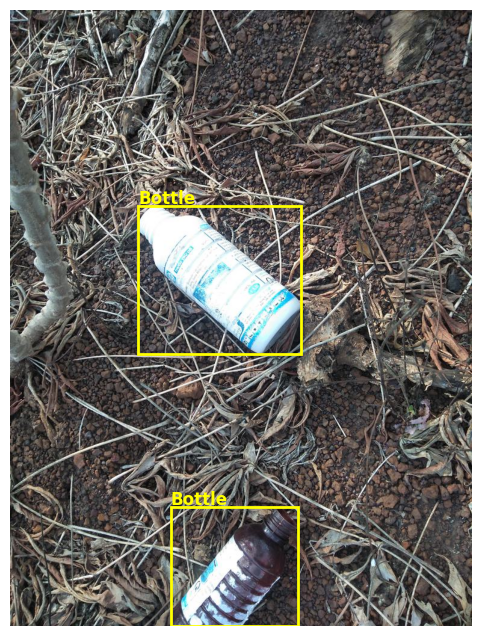

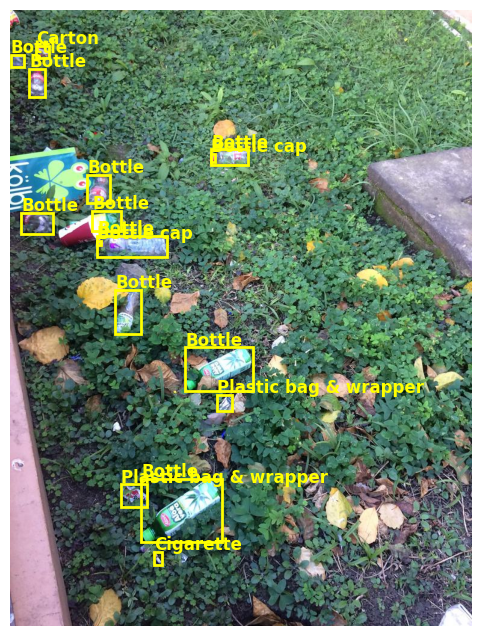


### Class: Bottle cap (id=3)


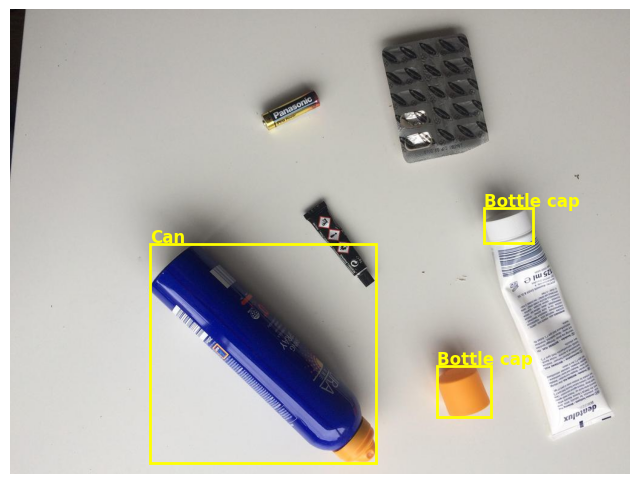

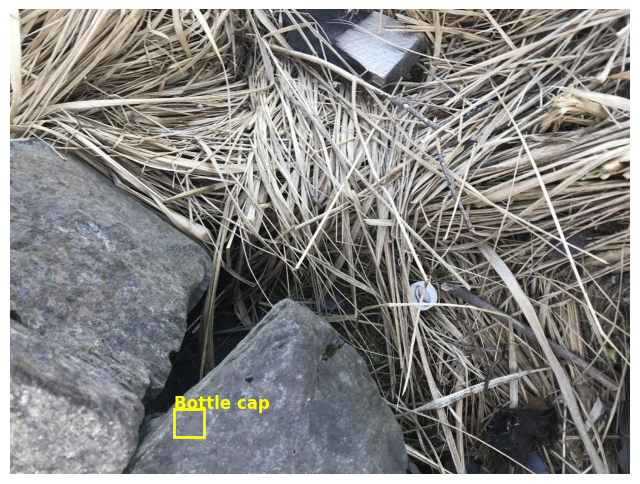


### Class: Can (id=4)


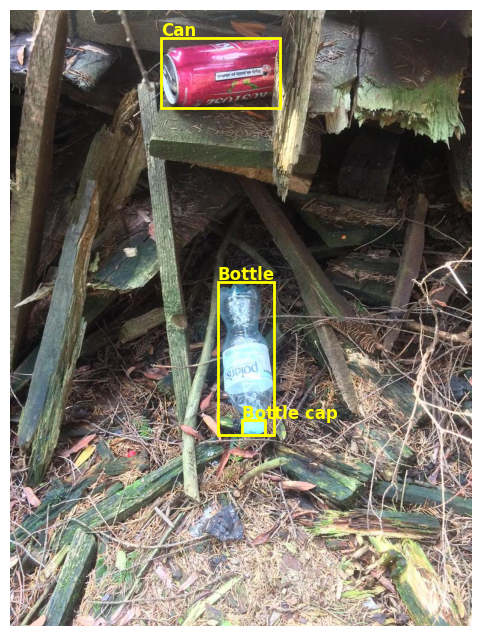

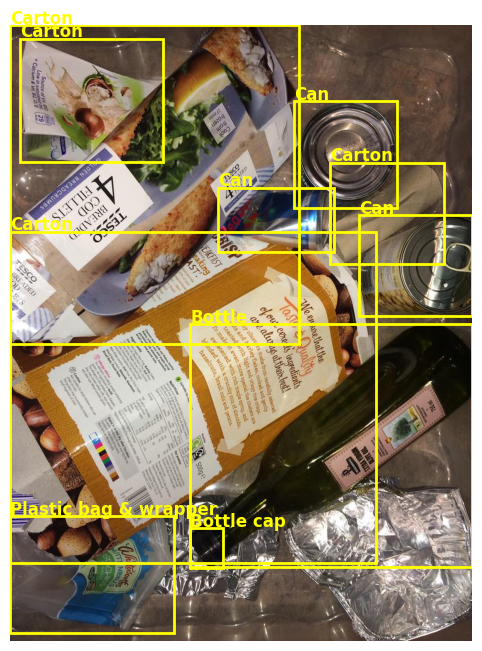


### Class: Carton (id=5)


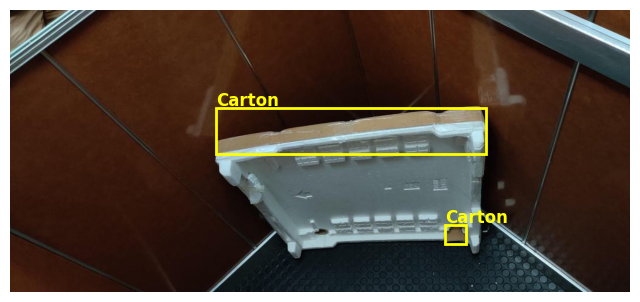

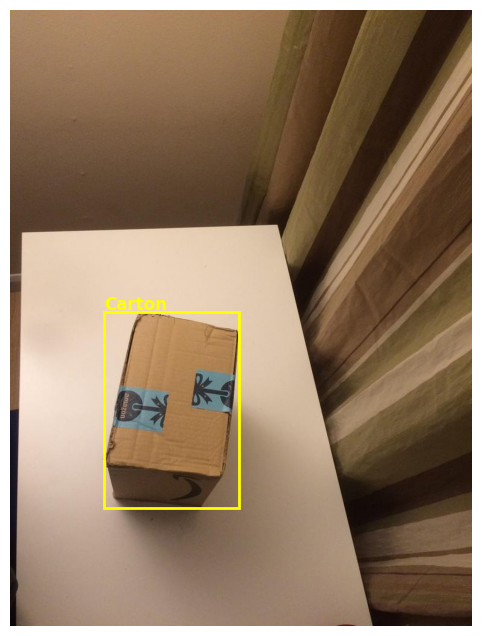


### Class: Plastic bag & wrapper (id=0)


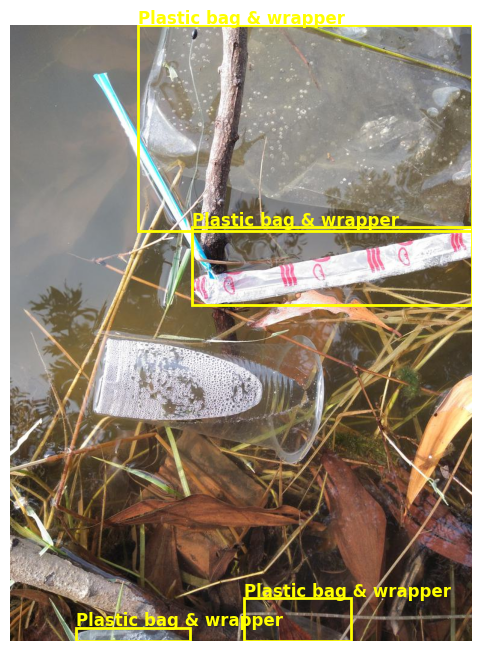

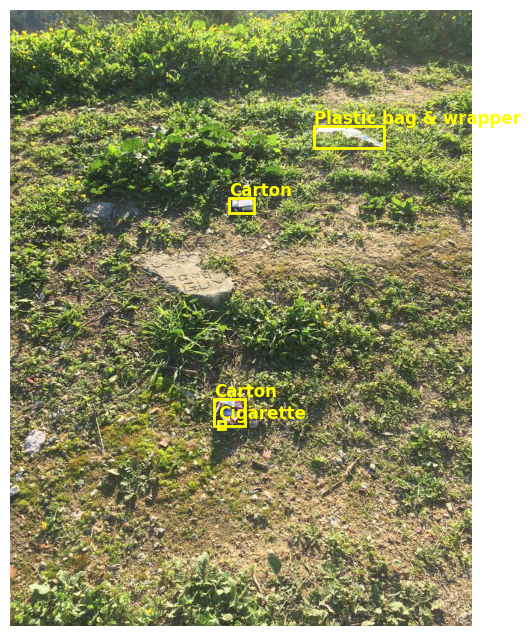


### Class: Cigarette (id=1)


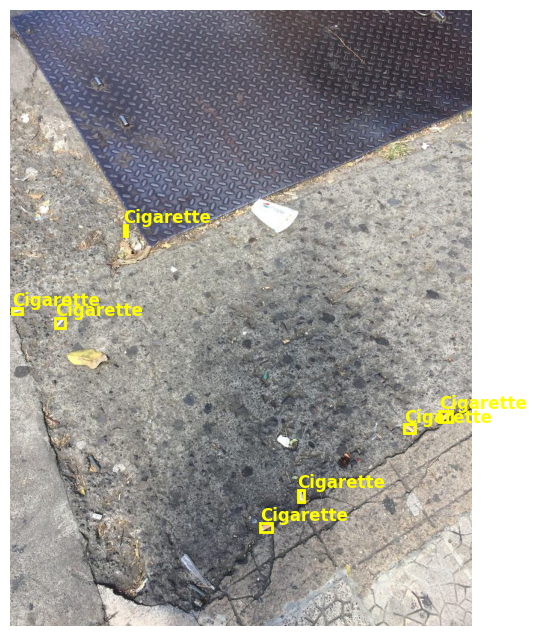

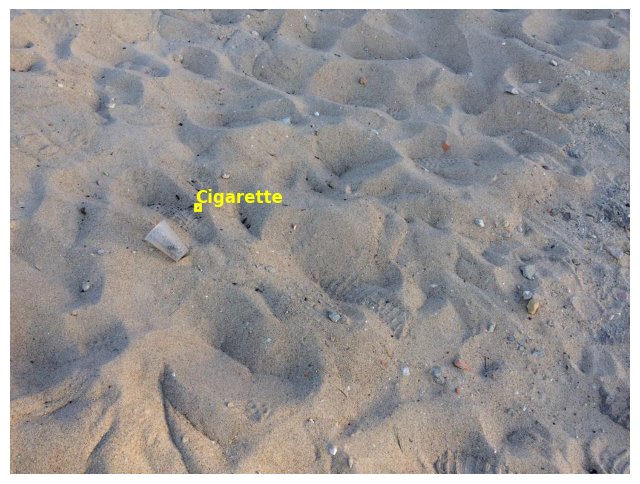

In [ ]:
visualize_examples_per_class(train_dataset, samples_per_class=2)


# Load Models

In [ ]:
from ultralytics import YOLO
from PIL import Image
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor, DetrForObjectDetection, DetrImageProcessor
import torch

#YOLO
yolo_model = YOLO('yolo11n.pt')

#DETR
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr_model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
detr_model.to(device)

#RT-DETR
rt_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd")
rt_processor = RTDetrImageProcessor.from_pretrained("PekingU/rtdetr_r50vd")
rt_model.eval()
rt_model.to(device)



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

RTDetrForObjectDetection(
  (model): RTDetrModel(
    (backbone): RTDetrConvEncoder(
      (model): RTDetrResNetBackbone(
        (embedder): RTDetrResNetEmbeddings(
          (embedder): Sequential(
            (0): RTDetrResNetConvLayer(
              (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (normalization): RTDetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (1): RTDetrResNetConvLayer(
              (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (normalization): RTDetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (2): RTDetrResNetConvLayer(
              (convolution): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (normalization): RTDetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
          )
          (pooler): MaxPool2d(

In [ ]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
from torchvision import transforms


def compute_iou(box1, box2):
  x1 = max(box1[0], box2[0])
  y1 = max(box1[1], box2[1])
  x2 = min(box1[2], box2[2])
  y2 = min(box1[3], box2[3])

  inter = max(0, x2 - x1) * max(0, y2 - y1)
  area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
  area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
  union = area1 + area2 - inter
  return inter / union if union > 0 else 0

def coco_to_xyxy(bbox):
  return [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]

def get_ground_truth(annotations):
  boxes, labels = [], []
  for ann in annotations:
    if ann['iscrowd'] == 0:
      boxes.append(coco_to_xyxy(ann['bbox']))
      labels.append(0)
  return torch.tensor(boxes), torch.tensor(labels)


def evaluate_model(model, dataset, processor=None, model_type='YOLO', conf_threshold=0.5, best_iou=False, device='cpu'):
  metric = MeanAveragePrecision()
  for img, annotations in tqdm(dataset):
      gt_boxes, gt_labels = get_ground_truth(annotations)
      num_objects = len(gt_boxes)
      if num_objects == 0:
          continue

      img_pil = transforms.ToPILImage()(img)

      # Inference
      if model_type == 'YOLO':
          results = model(img_pil, conf=conf_threshold, verbose=False)[0]
          boxes = results.boxes.xyxy.cpu()
          scores = results.boxes.conf.cpu()
      else:  # DETR / RT-DETR
          inputs = processor(images=img_pil, return_tensors="pt").to(device)
          with torch.no_grad():
              outputs = model(**inputs)
          target_sizes = torch.tensor([img_pil.size[::-1]]).to(device)
          results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=conf_threshold)[0]
          boxes = results['boxes'].cpu()
          scores = results['scores'].cpu()

      if best_iou:
          # Use top-10 boxes and select best IoU per GT
          sorted_idx = torch.argsort(scores, descending=True)[:10]
          top_boxes = boxes[sorted_idx]
          top_scores = scores[sorted_idx]
          selected_boxes, selected_scores = [], []
          for gt_box in gt_boxes:
              best_idx = max(range(len(top_boxes)), key=lambda i: compute_iou(gt_box.tolist(), top_boxes[i].tolist()))
              selected_boxes.append(top_boxes[best_idx])
              selected_scores.append(top_scores[best_idx])
          pred_boxes = torch.stack(selected_boxes)
          pred_scores = torch.stack(selected_scores)
      else:
          # Top-k boxes by confidence
          k = min(num_objects, len(boxes))
          sorted_idx = torch.argsort(scores, descending=True)[:k]
          pred_boxes = boxes[sorted_idx]
          pred_scores = scores[sorted_idx]

      pred_labels = torch.zeros(len(pred_boxes), dtype=torch.long)
      preds = [{'boxes': pred_boxes, 'scores': pred_scores, 'labels': pred_labels}]
      targets = [{'boxes': gt_boxes, 'labels': gt_labels}]
      metric.update(preds, targets)

  result = metric.compute()
  return result['map'].item(), result['map_50'].item()


In [ ]:

results = {}

configs = [
    ('YOLO', yolo_model, None, [0.1, 0.25, 0.5], False),
    ('DETR', detr_model, detr_processor, [0.3, 0.5, 0.7], False),
    ('RT-DETR', rt_model, rt_processor, [0.3, 0.5, 0.7], False),
    ('YOLO-BestIoU', yolo_model, None, [0.25], True)
]

for name, model, processor, thresholds, best_iou in configs:
    for conf in thresholds:
        try:
            map_val, map50 = evaluate_model(model, test_dataset, processor, name, conf, best_iou)
            results[f'{name}-conf{conf}'] = {'mAP': map_val, 'mAP50': map50}
        except Exception as e:
            print(f"Error with {name}-conf{conf}: {e}")

# Print results
print("\n" + "="*60)
print(f"{'Model':<30} {'mAP':>10} {'mAP50':>10}")
print("-"*60)
for name, metrics in sorted(results.items()):
    print(f"{name:<30} {metrics['mAP']:>10.4f} {metrics['mAP50']:>10.4f}")


  0%|          | 0/178 [00:00<?, ?it/s]

Error with YOLO-BestIoU-conf0.25: 'NoneType' object is not callable

Model                                 mAP      mAP50
------------------------------------------------------------
DETR-conf0.3                       0.0572     0.0863
DETR-conf0.5                       0.0525     0.0777
DETR-conf0.7                       0.0409     0.0593
RT-DETR-conf0.3                    0.0772     0.1013
RT-DETR-conf0.5                    0.0604     0.0721
RT-DETR-conf0.7                    0.0400     0.0487
YOLO-conf0.1                       0.0517     0.0630
YOLO-conf0.25                      0.0334     0.0389
YOLO-conf0.5                       0.0212     0.0234
